In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

# Intro to the NN API

Tensorflow has a nice api which includes many functions that we can call to build neural networks with tf.nn. Here, we will go over some basic functions that enable us to build a convolutional neural network (CNN) for a supervised classification task.

To build a neural network, we need to create:
 * NN model that takes inputs and makes a prediction
 * loss function -- takes NN model predictions and calculates an objective function
 * optimizer -- calculates gradients of loss function w.r.t. model parameters and updates
 * training loop -- cycle through data with mini-batches and update parameters
 
Let's first discuss the first part, building the NN model.  

## Intro to MLP

The multi-layer perceptron model is the standard neural network that first comes to mind when mentioning artificial neural networks.  It is a feed-forward neural network that takes as input a vector of input features, the has one or more hidden layers, with the number of neurons set by your heart's desire, followed by an output layer to make a prediction. If we are doing a simple linear regression, we just need one output neuron.  If we are classifying 10 different objects for a computer vision task, then we need 10 output neurons.  

Each hidden layer consist of a fully-connected layer, also known as a dense layer, that takes each of its inputs and calculates a weighted-sum to each hidden neuron.  Importantly, the weighted sum is then processed with a non-linear activation.  It turns out, theoretically, what this non-linear activation doesn't matter much. In practice, however, certain non-linear activations, like the rectified linear unit (ReLU), are easier to work with, making it easier to train deep neural networks. 

The MLP architecture has been well-characterized in terms of its expressive power and approximation capabilities.  Given enough hidden units, this kind of network can be considered a universal function approximator mapping the relationship between the input and the outputs.  

Let's build some basic components of a MLP!


Suppose we have 4 different mutations and we have a experimentally-determined fitness value.  I have processed this data, converting the amino-acids into a one-hot representation.  Thus, our goal is to see what the four mutations are and predict what the fitness level will be.  This is taken directly from:


### load fitness data and training labels

In [2]:
# load dataset
filename = '../data/elife-16965-supp1-v4.xlsx'
df = pd.read_excel(filename)

# parse variants and fitness
variants = df['Variants'].as_matrix()
fitness = df['Fitness'].as_matrix()

# filter data with a fitness of 0
index = np.where(fitness!=0)[0]
variants = variants[index]
fitness = fitness[index]

# create a one-hot vector for each variant
alphabet = 'ACEDGFIHKMLNQPSRTWVY'
num_alphabet = len(alphabet)
num_variants = len(variants)
one_hot = np.zeros((num_variants, num_alphabet, 4))
for i in range(num_variants):
    seq = str(variants[i])
    for j in range(len(seq)):
        index = alphabet.index(seq[j])
        one_hot[i,index,j] = 1
        
# normalize fitness
mu = np.mean(fitness)
sigma = np.std(fitness)
fitness = (fitness-mu)/sigma

# convert to float 32 for GPU analysis
one_hot = one_hot.astype(np.float32)
fitness = fitness.astype(np.float32)

In [43]:
np.random.seed(247) # for reproducibility

# split dataset into training cross validation and testing
train_size = 0.65
valid_size = 0.1
test_size = 0.25
split_size = [train_size, valid_size, test_size]


# generate a shuffled subset of data for train, validation, and test
num_seq = len(fitness)
cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]], num_seq)).astype(int) 

# randomly shuffle dataset
shuffle = np.random.permutation(num_seq)

# get shuffled indices for each data set
train_index = shuffle[range(cum_index[0], cum_index[1])]
valid_index = shuffle[range(cum_index[1], cum_index[2])]
test_index = shuffle[range(cum_index[2], cum_index[3])]

# create subsets of data based on indices 
X_train = one_hot[train_index]
Y_train = np.expand_dims(fitness[train_index], axis=1)
X_valid = one_hot[valid_index]
Y_valid = np.expand_dims(fitness[valid_index], axis=1)
X_test = one_hot[test_index]
Y_test = np.expand_dims(fitness[test_index], axis=1)

### Input layer

Next, we need to establish placeholders to be able to feed in input features into the MLP model. Since the data has an ndarray shape of 3, due to the one-hot representation, we need to flatten it such that it is a vector.  We can do this as a preprocessing step in numpy or we can include this reshape within the tensorflow graph.  

In [44]:
tf.reset_default_graph()

# placeholder
inputs = tf.placeholder(tf.float32, shape=[None, num_alphabet, 4])

# reshape the inputs to be flat
input_layer = tf.reshape(inputs, [-1, 4*num_alphabet])

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation. shape=None means that tensors of any shape will be accepted. Using shape=None is easy to construct graphs, but nightmarish for debugging. You should always define the shape of your placeholders as detailed as possible. 


## Weight Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In this most common case, the weights are initialized with the tf.truncated_normal and given their shape of a 2-D tensor with the first dim representing the number of units in the layer from which the weights connect and the second dim representing the number of units in the layer to which the weights connect. For the first layer, named hidden1, the dimensions are [IMAGE_PIXELS, hidden1_units] because the weights are connecting the image inputs to the hidden1 layer. The tf.truncated_normal initializer generates a random distribution with a given mean and standard deviation.

Then the biases are initialized with tf.zeros to ensure they start with all zero values, and their shape is simply the number of units in the layer to which they connect.

The graph's three primary ops -- two tf.nn.relu ops wrapping tf.matmul for the hidden layers and one extra tf.matmul for the logits -- are then created, each in turn, with separate tf.Variable instances connected to each of the input placeholders or the output tensors of the previous layer.


  Now, we are going to be instantiating tensorflow variables.  To do so, we need to initialize them.  A standard initialization used for neural networks is He-inits and Glorot-inits.  Here, we will use he inits.  Let's define a function for He-inits for the parameters and constant-inits for the bias terms.

In [30]:
# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

### Dense layer

For more details:
https://cs231n.github.io/convolutional-networks/


To help improve the results of our model, we also apply dropout regularization to our dense layer, using the dropout method in layers:

dropout = tf.layers.dropout(
    inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
Again, inputs specifies the input tensor, which is the output tensor from our dense layer (dense).

The rate argument specifies the dropout rate; here, we use 0.4, which means 40% of the elements will be randomly dropped out during training.

The training argument takes a boolean specifying whether or not the model is currently being run in training mode; dropout will only be performed if training is True. Here, we check if the mode passed to our model function cnn_model_fn is TRAIN mode.

In [31]:

# build a fully-connected layer (also known as a dense layer)
num_units = 256
num_incoming = 4*num_alphabet
W1 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W1')
b1 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b1')
dense_1 = tf.matmul(input_layer, W1)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b1)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)

Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [32]:

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dense_1_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob)


Logits Layer

The final layer in our neural network is the logits layer, which will return the raw values for our predictions. We create a dense layer with 10 neurons (one for each target class 0–9), with linear activation (the default):

logits = tf.layers.dense(inputs=dropout, units=10)
Our final output tensor of the CNN, logits, has shape [batch_size, 10].

Generate Predictions

The logits layer of our model returns our predictions as raw values in a [batch_size, 10]-dimensional tensor. Let's convert these raw values into two different formats that our model function can return:

The predicted class for each example: a digit from 0–9.
The probabilities for each possible target class for each example: the probability that the example is a 0, is a 1, is a 2, etc.
For a given example, our predicted class is the element in the corresponding row of the logits tensor with the highest raw value. We can find the index of this element using the tf.argmax function:

tf.argmax(input=logits, axis=1)
The input argument specifies the tensor from which to extract maximum values—here logits. The axis argument specifies the axis of the input tensor along which to find the greatest value. Here, we want to find the largest value along the dimension with index of 1, which corresponds to our predictions (recall that our logits tensor has shape [batch_size, 10]).

We can derive probabilities from our logits layer by applying softmax activation using tf.nn.softmax:

tf.nn.softmax(logits, name="softmax_tensor")

In [33]:

# build a fully-connected layer (also known as a dense layer)
W2 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W2')
b2 = tf.Variable(const_init(shape=[1], value=0.01), name='b2')
dense_2 = tf.matmul(dense_1_dropout, W2)


# add bias term
predictions = tf.nn.bias_add(dense_2, b2)

Calculate Loss

For both training and evaluation, we need to define a loss function that measures how closely the model's predictions match the target classes. For multiclass classification problems like MNIST, cross entropy is typically used as the loss metric. The following code calculates cross entropy when the model runs in either TRAIN or EVAL mode:

In [34]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
squared_error = tf.square(predictions - targets)
loss_function = tf.reduce_mean(squared_error)
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

In [35]:
# create session
sess = tf.Session()

# initialize all variables
sess.run(tf.global_variables_initializer())

In [36]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        

In [37]:
# path to save model parameters
save_path = '../results/epistasis'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'mlp')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
patience = 10         # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob: 0.5}
                          )
        train_loss += loss
        
    # check progress on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob: 1.0}
                                        )

    # calculate performance metrics
    pearsonr = np.corrcoef(Y_valid[:,0], valid_predict[:,0])[0][1]

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))
    
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

Epoch 1 of 50
  training loss:		0.874273
  validation loss:		0.781956
  validation Pearson r:		0.512640
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 2 of 50
  training loss:		0.717440
  validation loss:		0.675181
  validation Pearson r:		0.611325
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 3 of 50
  training loss:		0.599135
  validation loss:		0.555402
  validation Pearson r:		0.702041
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 4 of 50
  training loss:		0.496403
  validation loss:		0.462834
  validation Pearson r:		0.759627
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 5 of 50
  training loss:		0.423946
  validation loss:		0.395851
  validation Pearson r:		0.798019
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 6 of 50
  training 

Epoch 45 of 50
  training loss:		0.117118
  validation loss:		0.092698
  validation Pearson r:		0.956963
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 46 of 50
  training loss:		0.112615
  validation loss:		0.091167
  validation Pearson r:		0.958456
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 47 of 50
  training loss:		0.113856
  validation loss:		0.090733
  validation Pearson r:		0.958594
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 48 of 50
  training loss:		0.113309
  validation loss:		0.089236
  validation Pearson r:		0.958570
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 49 of 50
  training loss:		0.106799
  validation loss:		0.088635
  validation Pearson r:		0.959969
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 50 of 50
  tra

In [38]:
# close tensorflow session (Note, the graph is still open)
sess.close()

In [39]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/VTS1'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/VTS1/simple_cnn_rnacompete


In [40]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob: 1.0})

# calculate performance metrics
pearsonr = np.corrcoef(Y_test[:,0], test_predict[:,0])[0][1]


print("  validation loss:\t\t{:.6f}".format(test_loss))
print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))

  validation loss:		0.097278
  validation Pearson r:		0.955959


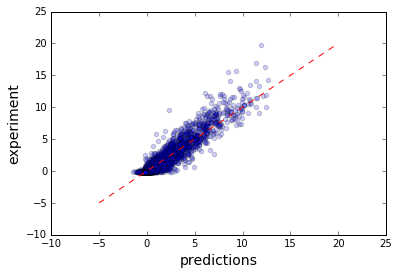

In [42]:
plt.figure()
plt.scatter(test_predict[:,0], Y_test[:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)
plt.plot([-5,20],[-5,20],'--r')

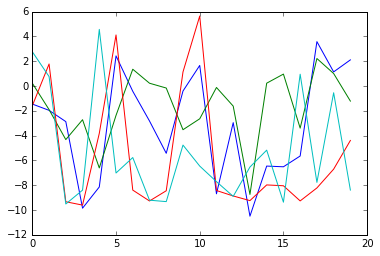

In [22]:
# let's get the highest predicted sequence 
max_index = np.argsort(test_predict[:,0])[::-1]

# get sequence
index = 1
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(predictions, inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob: 1.0})

plt.plot(np.squeeze(backprop_saliency[0]));

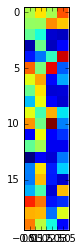

In [28]:
plt.imshow(backprop_saliency[0][0], interpolation='None')

Training

In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define what it means for a model to be bad. We call this the cost, or the loss, and it represents how far off our model is from our desired outcome. We try to minimize that error, and the smaller the error margin, the better our model is.

One very common, very nice function to determine the loss of a model is called "cross-entropy." Cross-entropy arises from thinking about information compressing codes in information theory but it winds up being an important idea in lots of areas, from gambling to machine learning. It's defined as:

Hy′(y)=−∑iyi′log⁡(yi)

Where y is our predicted probability distribution, and y′ is the true distribution (the one-hot vector with the digit labels). In some rough sense, the cross-entropy is measuring how inefficient our predictions are for describing the truth. Going into more detail about cross-entropy is beyond the scope of this tutorial, but it's well worth understanding.

To implement cross-entropy we need to first add a new placeholder to input the correct answers:

y_ = tf.placeholder(tf.float32, [None, 10])

Then we can implement the cross-entropy function, −∑y′log⁡(y):

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
First, tf.log computes the logarithm of each element of y. Next, we multiply each element of y_ with the corresponding element of tf.log(y). Then tf.reduce_sum adds the elements in the second dimension of y, due to the reduction_indices=[1] parameter. Finally, tf.reduce_mean computes the mean over all the examples in the batch.

Note that in the source code, we don't use this formulation, because it is numerically unstable. Instead, we apply tf.nn.softmax_cross_entropy_with_logits on the unnormalized logits (e.g., we call softmax_cross_entropy_with_logits on tf.matmul(x, W) + b), because this more numerically stable function internally computes the softmax activation. In your code, consider using tf.nn.softmax_cross_entropy_with_logits instead.
Now that we have defined our model and training loss function, it is straightforward to train using TensorFlow. Because TensorFlow knows the entire computation graph, it can use automatic differentiation to find the gradients of the loss with respect to each of the variables. TensorFlow has a variety of built-in optimization algorithms. For this example, we will use steepest gradient descent, with a step length of 0.5, to descend the cross entropy.

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
What TensorFlow actually did in that single line was to add new operations to the computation graph. These operations included ones to compute gradients, compute parameter update steps, and apply update steps to the parameters.

The returned operation train_step, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step.


We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.

We then generate a single variable to contain a counter for the global training step and the tf.train.Optimizer.minimize op is used to both update the trainable weights in the system and increment the global step. This op is, by convention, known as the train_op and is what must be run by a TensorFlow session in order to induce one full step of training (see below).

global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimizer.minimize(loss, global_step=global_step)


In [14]:
sess.run(loss_function, feed_dict={inputs: X_valid, 
                              targets: Y_valid, 
                              keep_prob: 0.5})

1.2103885

### Evaluating Our Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.


How well does our model do?

Well, first let's figure out where we predicted the correct label. tf.argmax is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, while tf.argmax(y_,1) is the correct label. We can use tf.equal to check if our prediction matches the truth.

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75.

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
Finally, we ask for our accuracy on our test data.

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
This should be about 92%.


Load Training and Test Data

First, let's load our training and test data. Add a main() function to cnn_mnist.py with the following code:

We store the training feature data (the raw pixel values for 55,000 images of hand-drawn digits) and training labels (the corresponding value from 0–9 for each image) as numpy arrays in train_data and train_labels, respectively. Similarly, we store the evaluation feature data (10,000 images) and evaluation labels in eval_data and eval_labels, respectively.



Save a Checkpoint

In order to emit a checkpoint file that may be used to later restore a model for further training or evaluation, we instantiate a tf.train.Saver.

saver = tf.train.Saver()
In the training loop, the tf.train.Saver.save method will periodically be called to write a checkpoint file to the training directory with the current values of all the trainable variables.

saver.save(sess, FLAGS.train_dir, global_step=step)
At some later point in the future, training might be resumed by using the tf.train.Saver.restore method to reload the model parameters.

saver.restore(sess, FLAGS.train_dir)

In [ ]:


hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
logits = tf.matmul(hidden2, weights) + biases


After initializing the variables with the session, training may begin.


The user code controls the training per step, and the simplest loop that can do useful training is:
for step in xrange(FLAGS.max_steps):
    sess.run(train_op)
However, this tutorial is slightly more complicated in that it must also slice up the input data for each step to match the previously generated placeholders.

For each step, the code will generate a feed dictionary that will contain the set of examples on which to train for the step, keyed by the placeholder ops they represent.

A python dictionary object is then generated with the placeholders as keys and the representative feed tensors as values.

feed_dict = {
    images_placeholder: images_feed,
    labels_placeholder: labels_feed,
}
This is passed into the sess.run() function's feed_dict parameter to provide the input examples for this step of training.

The code specifies two values to fetch in its run call: [train_op, loss].

for step in xrange(FLAGS.max_steps):
    feed_dict = fill_feed_dict(data_sets.train,
                               images_placeholder,
                               labels_placeholder)
    _, loss_value = sess.run([train_op, loss],
                             feed_dict=feed_dict)

Because there are two values to fetch, sess.run() returns a tuple with two items. Each Tensor in the list of values to fetch corresponds to a numpy array in the returned tuple, filled with the value of that tensor during this step of training. Since train_op is an Operation with no output value, the corresponding element in the returned tuple is None and, thus, discarded. However, the value of the loss tensor may become NaN if the model diverges during training, so we capture this value for logging.

Assuming that the training runs fine without NaNs, the training loop also prints a simple status text every 100 steps to let the user know the state of training.

# official tutorials

https://www.tensorflow.org/tutorials/



# lower-level APIs

https://www.tensorflow.org/api_docs/python/tf/nn
    
    
tf.nn.conv2d
tf.nn.dropout
tf.nn.max_pool

tf.nn.batch_normalization
tf.nn.dilation2d
tf.nn.embedding_lookup
tf.nn.raw_nn
tf.nn.dynamic_rnn


tf.nn.sigmoid
tf.nn.redlu
tf.nn.tanh
tf.nn.softmax
tf.nn.softplus



# Layers 

The tf.layers module contains methods to create each of the three layer types above:

* conv2d(). Constructs a two-dimensional convolutional layer. Takes number of filters, filter kernel size, padding, and activation function as arguments.
* max_pooling2d(). Constructs a two-dimensional pooling layer using the max-pooling algorithm. Takes pooling filter size and stride as arguments.
* dense(). Constructs a dense layer. Takes number of neurons and activation function as arguments.

Each of these methods accepts a tensor as input and returns a transformed tensor as output. This makes it easy to connect one layer to another: just take the output from one layer-creation method and supply it as input to another.
    
https://www.tensorflow.org/api_docs/python/tf/layers
  
* tf.nn.layers.conv2d()
* tf.nn.layers.dense
* tf.nn.layers.dropout
* tf.nn.layers.max_pooling2d
* tf.nn.layers.batch_normalization


# alternative 

* tf.contrib.layers
* tf.keras.layers